<center><h1>Contour Mapping</h1><h5>by Rebecca Hinrichs</h5><h5>∙ a discussion with examples ∙</h5><h5>FALL 2023</h5></center>

--- 
---

--- 

1.	How does Local Binary Pattern (LBP) method work? Explain how it is "illumination invariant"? Showcase your understanding of LBP with a custom program.

<center><hr style="width: 50%; border-color: black;"></center><br>

LBP is a Feature Descriptor algorithm, which takes a 3-dimensional image and translates it into a single-dimension vector. The Local Binary Pattern algorithm divides an image into patches (for example, a 16x16 window of the entire image) and further breaks down each patch into smaller subset patches (in our 16x16 example: it breaks the patch into 4 smaller 8x8 patches- I'll refer to these as sub-patches). For each sub-patch, the algorithm calculates its neighborhood value. To do this, the program retains in its memory the central pixel's numerical value and moves in a user-determined clockwise or counter-clockwise pattern around the pixel in the sub-patch, converting each surrounding pixel to $0$ if the numerical value is larger than the central pixel or $1$ if lower. The 8-digit byproduct of $1$'s and $0$'s (in the case of working with a 3x3 sub-patch) is then given a single integer value for that patch by calculating the binary representation of the output. Each patch is then concatenated and normalized (optional) to offer a feature vector of the entire image. This feature vector can then be delivered to classification algorithms such as SVD and ANN. LBP is often used for facial recognition and image segmentation, as well as texture analysis and biomedical image analysis classification tasks.

In [1]:
import os
working_directory = 'C:\\Users\\beanl\\Downloads\\BACKUP\\CS 6305\\Assignments\\Homework 05 DUE 07 Nov 23'
os.chdir(working_directory)
os.getcwd()

'C:\\Users\\beanl\\Downloads\\BACKUP\\CS 6305\\Assignments\\Homework 05 DUE 07 Nov 23'

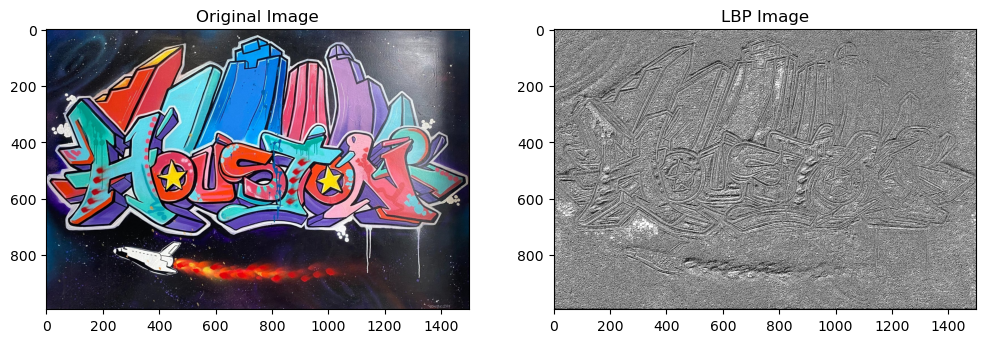

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to process an image using LBP
def lbp_operation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
    lbp_image = np.zeros_like(gray) # initialize the LBP image

    # Define the patch size (3x3)
    for i in range(1, gray.shape[0] - 1):
        for j in range(1, gray.shape[1] - 1):
            # Extract the 3x3 patch
            neighbor = gray[i - 1:i + 2, j - 1:j + 2]
            center = gray[i, j]
            # Apply LBP
            binary = (neighbor >= center).astype(int)
            binary_str = ''.join(str(int(b)) for b in binary.flatten()[[0, 1, 2, 5, 8, 7, 6, 3]])
            lbp_value = int(binary_str, 2)
            lbp_image[i, j] = lbp_value
    return lbp_image

# Import the image
image_path = 'Space+City.jpg'
image = cv2.imread(image_path)

# Apply LBP operation
lbp_image = lbp_operation(image)

# Display both original and LBP images
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(122), plt.imshow(lbp_image, cmap='gray'), plt.title('LBP Image')
plt.show();

--- 

2.	How is the Histogram of Oriented Gradient (HOG) feature computed? Showcase your understanding of HOG with 
a custom program.

<center><hr style="width: 50%; border-color: black;"></center><br>

HoG is a Feature Descriptor algorithm, which takes a 3-dimensional image and translates it into a single-dimension vector. The Histogram of Oriented Gradient algorithm utilizes both magnitude and direction (gradient orientation) in a localized portion of the image in 3 steps. <br>
- <b>Step 1:</b> It first preprocesses the image by dividing it to patches (see the process I described for the LBP). It then proceeds to process Steps 2-4 patchwise.
- <b>Step 2:</b> The HoG then calculates the gradient values. The gradient magnitude as $| \nabla{f(x,y)} |= \sqrt{f_x^2 + f_y^2}$, and the gradient orientation by $\theta = tan^{-1}(\frac{g_y}{g_x})$- in other words, the derivative for each pixel-to-pixel shift both vertically and horizontally- making it able to account for increases or decreases in the numerical value of neighboring pixels and determine the strongest shifts of light intensity most typically representative of edges and corners in an image. Specifically, the HoG filters the image with convolution kernels $\nabla{f} = \left( \frac{\partial I}{\partial x}, \frac{\partial I}{\partial y} \right)$ where $I$ represents the image pixel value and multiplies it by $[-1,0,1]$ with a $1x3$ and a $3x1$ vector for the $x,y$ directions respectively. This process creates $2$ output matrices for each patch. The algorithm accounts for color images by computing $\nabla{f(x,y)}$ and $\theta$ for each pixel's RGB channel separately- making $6$ matrices per patch.
- <b>Step 3:</b> Next, the HoG concatenates the outputs as a histogram in order to determine the most dramatic shifts in light intensity. For each patch, a histogram is compiled by normalizing the outputs of Step 2 and binning them. For example: if the first pixel's direction is calculated as 80, and the corresponding magnitude of that pixel is calculated as 2, then in "bin 80", the algorithm places a value of 2 (representing the number of occurrences). The bins are stacked from 0 to 180 for values of 20 per bin. If the value is on a threshold- say that pixel is value 10, which can neither be placed in the bin stack 0 or 20- then its corresponding magnitude value of 2 will be divided between the two bins, so that 1 goes to the 0 bin and 1 goes to the 20 bin. The bins are valued as stacks of 20 for numbers up to 180 because the x-axis direction or y-axis direction each contain up to 180°, and there are 9 total pixels in a 3x3 patch, so $\frac{180°}{9} = 20$.
- <b>Step 4:</b> The output of the last step gave us RGB color vectors, which we now apply <i>L2 Normalization (Euclidean distance)</i> to normalize the vector.
- <b>Step 5:</b> Finally, the HoG calculates the feature vector of the entire image by concatenating all of the patches into a single-dimension vector to feed to our classifiers.

The additional calculation for orientation makes the HoG algorithm a bit more computationally expensive than the LBP algorithm, but significantly more powerful. HoG is very useful for object detection and recognition. Both LBP and HoG are <i>handcrafted feature</i> models, which require user input and manipulation.

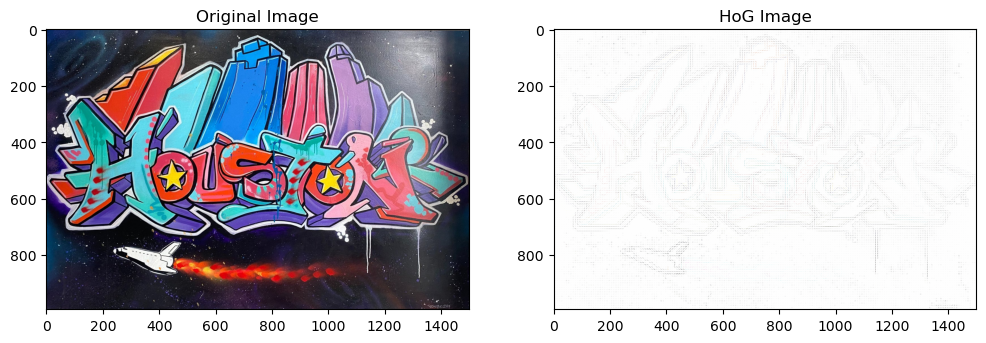

In [3]:
# Import additional ML Dependencies
from skimage import io, feature
from skimage.transform import resize

# Function to process an image using HoG
def hog_operation(image):
    """ Compute HOG image for visualization for a single channel """
    _, hog_image = feature.hog(image, 
                               orientations=9, 
                               pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), 
                               visualize=True, 
                               block_norm='L2-Hys')
    return hog_image

# Import the image
image = io.imread(image_path)

# Compute HOG features for each color channel
hog_image_r = hog_operation(image[:, :, 0])
hog_image_g = hog_operation(image[:, :, 1])
hog_image_b = hog_operation(image[:, :, 2])

# Normalize each HOG image to [0, 1] for visualization
hog_image_r = (hog_image_r - hog_image_r.min()) / (hog_image_r.max() - hog_image_r.min())
hog_image_g = (hog_image_g - hog_image_g.min()) / (hog_image_g.max() - hog_image_g.min())
hog_image_b = (hog_image_b - hog_image_b.min()) / (hog_image_b.max() - hog_image_b.min())

# Concatenate HOG features from all channels into a single 3-channel image
hog_image = np.stack((hog_image_r, hog_image_g, hog_image_b), axis=-1)

# Display both original and HOG images
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(image), plt.title('Original Image')
plt.subplot(122), plt.imshow(1-hog_image, cmap='gray'), plt.title('HoG Image') # '1-hog_image' to invert black & white
plt.show();

<b>Note:</b> I inverted the output of the HoG image in order to better demonstrate the feature detection output visually for you. Notice the difficulty to visualize the features are because of the convolved output, defining the "gradient" rather than the hard-lined output we saw with LBP. Below, see each channel output.

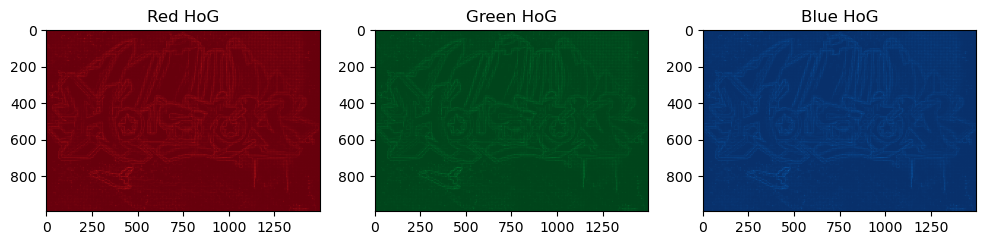

In [4]:
# Display the per-channel HOG image features
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(1-hog_image_r, cmap='Reds'), plt.title('Red HoG')
plt.subplot(132), plt.imshow(1-hog_image_g, cmap='Greens'), plt.title('Green HoG')
plt.subplot(133), plt.imshow(1-hog_image_b, cmap='Blues'), plt.title('Blue HoG')
plt.show();

--- 

3.	Explain the SIFT algorithm. Make a clustered image of yourself and your sibling in an image and make a distinct image of yourself, computing feature matching with the help of SIFT.

<center><hr style="width: 50%; border-color: black;"></center><br>

SIFT is a Feature Descriptor algorithm, which takes a 3-dimensional image and translates it into a single-dimension vector. Developed by David Lowe in 1999, the Scale Invariant Feature Transform algorithm is widely used for tasks like object recognition, robotic mapping and navigation, image stitching, 3D modeling, gesture recognition, video tracking, and match moving. SIFT can be described with its $4$ major components: $f=(x,y,\sigma,\theta,(128-\text{feature vector}))$. It utilizes <i>Scale-Space Extrema Detection</i> to search over multple scales and image locations (its $(x,y)$ <b>spatial</b> component), <i>KeyPoint Localization</i> to fit a model to determine location and scale (its $\sigma$ <b>Gaussian edge/blur</b> component), <i>Orientation Assignment</i> to compute the best orientation for each keypoint region (its $\theta$ <b>principal pirection</b> component), and <i>KeyPoint Description</i> to use local image gradients at selected scale and rotation in order to describe each keypoint region (its $128-\text{feature vector}$ component). <br> 
The SIFT algorithm involves several key steps: <br>
- <b>Step 1: Scale-Space Extrema Detection:</b> The first step in SIFT is to identify key points (interesting points or features) in the image. This is done using the concept of scale space, which essentially means looking at the image at different scales (sizes or resolutions).
- <b>Step 2: Keypoint Localization:</b> The algorithm uses a Difference of Gaussians (DoG) function to identify potential interest points that are invariant to scale and orientation. Once potential keypoints are found, SIFT refines them to achieve more accurate results. This involves eliminating low-contrast keypoints and edge responses to improve stability.
- <b>Step 3: Orientation Assignment:</b> For each keypoint, orientations are assigned based on the direction of the gradient. This ensures that the keypoint descriptor is rotation invariant. Each keypoint can have one or multiple orientations, leading to multiple keypoints for one location.
- <b>Step 4: KeyPoint Description:</b> A descriptor is created for each keypoint. The region around the keypoint is divided into subregions, and for each subregion, a histogram of gradient directions is computed. These histograms are concatenated to form a final descriptor vector for the keypoint. The length of this descriptor is typically 128 elements. This high-dimensional vector essentially captures the local image gradients around the keypoint, making the descriptor robust to changes in illumination, noise, and minor changes in viewpoint. <br>

In the context of comparing two images, keypoints between images are matched by identifying the nearest neighbors between feature spaces (e.g., using Euclidean distance of their descriptors). SIFT is particularly powerful in scenarios where the object's scale, rotation, and viewpoint might change between different images. This makes it suitable for applications like object recognition, image stitching and panorama creation, 3D modeling, motion tracking, and robot navigation. However, due to its complexity, the algorithm is even more computationally intensive than its LBP and HoG forebears, though far more powerful still.

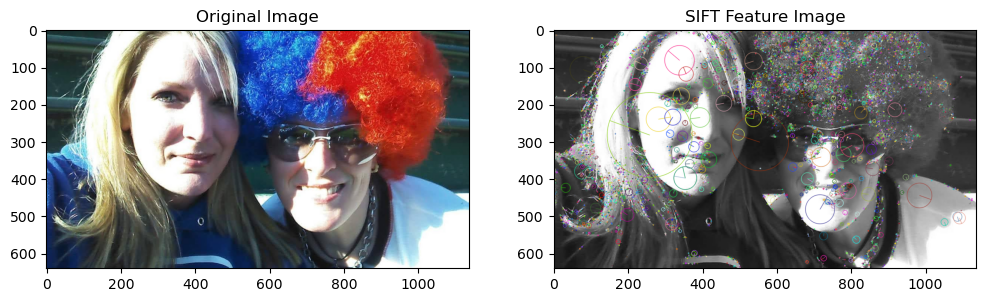

In [6]:
# Import the image
image = cv2.imread('Sissy&Me_ChicagoCubs2011.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute SIFT descriptors
keypoints, descriptors = sift.detectAndCompute(image, None)

# Draw keypoints on the image
output_image = cv2.drawKeypoints(gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Save the output image with keypoints
cv2.imwrite('output_image.jpg', output_image)

# You can also save the SIFT descriptors to a file for later use
with open('sift_descriptors.txt', 'w') as file:
    for descriptor in descriptors:
        descriptor_str = ' '.join(str(x) for x in descriptor)
        file.write(descriptor_str + '\n')

# Display the original & SIFT feature images
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(122), plt.imshow(output_image, cmap='gray'), plt.title('SIFT Feature Image')
plt.show();

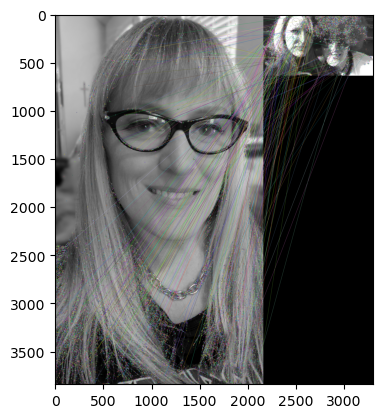

In [7]:
# Load two images you want to match
image1 = cv2.imread('Rebecca_selfie.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('output_image.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute SIFT descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Create a Brute-Force Matcher object for descriptor matching
bf = cv2.BFMatcher()

# Match descriptors from image1 to image2
matches = bf.knnMatch(descriptors1, descriptors2, k=2)  # k=2 means to find the two best matches

# Apply a ratio test to keep only good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw the good matches on the images
matching_result = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None)

# Save the matching result
cv2.imwrite('matching_result.jpg', matching_result)
plt.imshow(matching_result)
plt.show();

Assuming I was matched to my sister due to my costume in the original photo ☺ Let's see if we can isolate just my face in order to get successful detection...

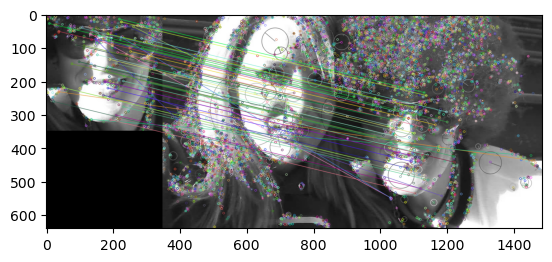

In [8]:
# Load two images you want to match
image1 = cv2.imread('Me_ChicagoCubs2011.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('output_image.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute SIFT descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Create a Brute-Force Matcher object for descriptor matching
bf = cv2.BFMatcher()

# Match descriptors from image1 to image2
matches = bf.knnMatch(descriptors1, descriptors2, k=2)  # k=2 means to find the two best matches

# Apply a ratio test to keep only good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw the good matches on the images
matching_result = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None)

# Save the matching result
cv2.imwrite('matching_result.jpg', matching_result)
plt.imshow(matching_result)
plt.show();

We were able to show that we need to isolate the face alone in order for this to work. <br>
Let's try again using a cropped version of the original selfie against this photo to see if we can cross-reference our photos to find the same person.

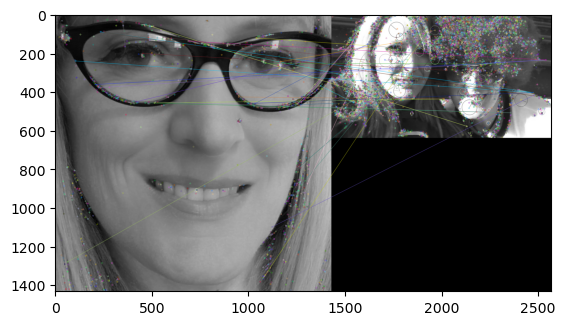

In [9]:
# Load two images you want to match
image1 = cv2.imread('Rebecca_selfie_cropped.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('output_image.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute SIFT descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Create a Brute-Force Matcher object for descriptor matching
bf = cv2.BFMatcher()

# Match descriptors from image1 to image2
matches = bf.knnMatch(descriptors1, descriptors2, k=2)  # k=2 means to find the two best matches

# Apply a ratio test to keep only good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw the good matches on the images
matching_result = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None)

# Save the matching result
cv2.imwrite('matching_result.jpg', matching_result)
plt.imshow(matching_result)
plt.show();

By examining the output, we observe that the curve of my glasses were mapped to the curve in my sister's cheekbone, giving her a majority of the mapping features to my face. <br><br> Our second image- using the cropped version of a portion of the same image- was the most successful using the SIFT detector. However, we see that the detector still struggles to cross-reference a single person across different photos, as evident in the third image. <br><br> In future applications, we could try weighting the features of the face in order to allow for costumes, sunglasses, different clothes, etc across many different environments and photographs.

<br>

--- 

<center><i>Thank you!</i>

<hr style="width: 50%; border-color: black;"></center><br>